# Preprocessing
## Imports

In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as transforms
import tarfile
import pandas as pd
import cv2
from PIL import Image, ImageFilter

### Opening Data Files

In [3]:
def open_tar(filename, dest=None):
    with tarfile.open(filename, 'r:gz') as tar:
        if dest is None:
            tar.extractall('./')
        else:
            tar.extractall(dest)
    print("Extraction successful!")

Below extracts into pokemon/icons path

In [4]:
open_tar("./datasource/pokemon-icons.tar.gz")

Extraction successful!


Below extracts into pokemon/main-sprites path

In [5]:
open_tar("./datasource/generation-1.tar.gz")

Extraction successful!


### Create Pokedex
Pokedex for our purpose is simply a pandas dataframe that maps a pokemon's index to its name. Many images are simply called "1.png" so this data structure allows us to determine that "1.png" is bulbasaur

In [6]:
def make_pokedex(path="pokedex/pokemon.csv"):
    pokedex = pd.read_csv(path)
    return pokedex

In [7]:
pokedex = make_pokedex()
print(pokedex)

            Name     Type1   Type2
0      bulbasaur     Grass  Poison
1        ivysaur     Grass  Poison
2       venusaur     Grass  Poison
3     charmander      Fire     NaN
4     charmeleon      Fire     NaN
..           ...       ...     ...
804    stakataka      Rock   Steel
805  blacephalon      Fire   Ghost
806      zeraora  Electric     NaN
807       meltan     Steel     NaN
808     melmetal     Steel     NaN

[809 rows x 3 columns]


Here I determine the name of the pokemon located at index 49

In [8]:
pokedex["Name"][49]

'diglett'

## Image Augmentation

In [9]:
# Sample image to test augmentations on
img = Image.open("pokedex/images/images/abra.png")
img.show()

### Rotation

In [10]:
# Rotates an image by a random amount. Set the "rot" parameter if you want to rotate by a specific degree amount
def img_rotate(img, rot=None):
    if rot is None:
        rot = np.random.uniform(0, 360)
    
    rot_img = img.rotate(rot)
#     rot_img.show(title="Rotated Image")
    return rot_img

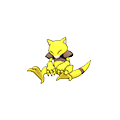

In [11]:
# Test random rotation
img_rotate(img)

### Todo: (Add noise, zoom in, etc?)

### Additional Augments

#### Gaussian Blur

In [12]:
def gaussian_blur(img, kernel_size=2):
    # mean is the center of the gaussian distribution
    # var is the variance of the gaussian distribution

    return img.filter(ImageFilter.GaussianBlur(kernel_size))

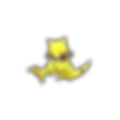

In [13]:
# Test gaussian blur with radius of 2
gaussian_blur(img)

#### Adding Gaussian Noise

In [14]:
def add_noise(img, mean=0, var=1):
    img_data = np.array(img)

    noise = np.random.normal(mean, var, img_data.shape)

    return Image.fromarray(np.clip(img_data + noise, 0, 255).astype('uint8'))

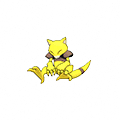

In [15]:
# Test adding gaussian noise with 0 mean and unit variance
add_noise(img)

#### Zooming In

In [16]:
def img_zoom(img, scale_factor=2):
    img_data = np.array(img)
    h, w = img_data.shape[:2]

    # Height and width midpoints
    hm, wm = h / 2, w / 2

    # Half of window size for height and width
    hz, wz = h / (2 * scale_factor), w / (2 * scale_factor)

    # Upper and lower bounds for height
    uh, lh = int(hm - hz), int(hm + hz)
    
    # Upper and lower bounds for width
    uw, lw = int(wm - wz), int(wm + wz)

    # Resize cropped image to fit original size
    zoomed_img = cv2.resize(img_data[uh:lh, uw:lw], dsize=(h, w))

    return Image.fromarray(zoomed_img)

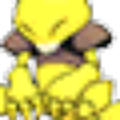

In [17]:
# Test 4x zoom into image
img_zoom(img, 4)

## Organize Samples

### Locations with images that are useful:
* pokemon/main-sprites (png for all pixelated gen1 pokemon!)
    * ./red-blue (red/blue version of sprites)
    * ./red-green (red/green version of sprites)
    * ./yellow (yellow version of sprites)
    
* pokedex/images/images (high def images)

* pokemon/icons (pixelated images and root of below subfolders. Not all pokemon have them!)
    * pokemon/icons/old (pixelated old images. Not all pokemon have them!)
    * pokemon/icons/right (pixelated images flipped. Not all pokemon have them!)

**Currently I only load all subfolders of pokemon/main-sprites because the images are pixelated and there is one for each pokemon**

In [18]:
# Saves an image at the "dest" path with a unique name tracked by the "counter" dict.
# img: The image to be saved
# name: The name of the pokemon
# ind: The index of the pokemon
# dest: The destination. Which subfolder will the image be saved in
# counter: A dictionary that keeps track of how many images are in each of the pokemon subfolders
    # The image's file name is determined by this count, found by indexing the dict with pokemon's "ind"
    # After each save, this function increment's the pokemon's counter by 1

def smart_save(img, name, ind, dest, counter):
    fname = name + str(counter[ind]) + ".png"
    img.save(dest + fname)
    counter[ind] += 1

In [19]:
# Organizes and augments samples to be used for training
# start_ind/end_ind: The index range of the pokemon to be used for classification
# pokedex: See above section "Create Pokedex". A pandas dataframe associating pokemon ind to name
# augment: A dictionary where augment parameters are defined. Empty dict means only use source images w/out augment
    # If the key "rotate" is present, include x rotated versions of the source images where x in the value
        #associated with the key
        
def sample_data(start_ind, end_ind, pokedex, augment={}):
    # Define the sources where images will be drawn from
    sources = []
    rb_sprites = "./pokemon/main-sprites/red-blue/"
    sources.append(rb_sprites)
    rg_sprites = "./pokemon/main-sprites/red-green/"
    sources.append(rg_sprites)
    y_sprites = "./pokemon/main-sprites/yellow/"
    sources.append(y_sprites)
    
    # The file_counter keeps track of how many images are currently saved for each pokemon
    # The keys in this case are the pokemon's index
    file_counter = dict(enumerate([0] * (end_ind - start_ind)))
    for ind in range(start_ind, end_ind):
        # Use pokedex to get the pokemon's name and create the subfolder for its images
        name = pokedex["Name"][ind]
        class_directory = './samples/' + name + "/"
        if not os.path.exists(class_directory):
            os.makedirs(class_directory)
        
        # indices start at 0 but pokemon id's start at 1. Define the source image using pokemon id
        id_ = ind + 1
        source_img = str(id_) + ".png"
        # For each source defined, open and save the image. Apply augmentations and save modified imgs if applicable
        for source in sources:   
            try:
                img = Image.open(source + source_img)
                smart_save(img, name, ind, class_directory, file_counter)
                
                # Augmentations begin here
                rotations = 0 if "rotate" not in augment else augment["rotate"]
                zoom_params = [] if "zoom" not in augment else augment["zoom"]
                blur_params = [] if "blur" not in augment else augment["blur"]
                noise_params = [] if "noise" not in augment else augment["noise"]
                for _ in range(rotations):
                    rot_img = img_rotate(img)
                    smart_save(rot_img, name, ind, class_directory, file_counter)

                    # Add zoom to current rotation of image
                    for scale in zoom_params:
                        rot_zoom = img_zoom(rot_img.convert('RGBA'), scale)
                        smart_save(rot_zoom, name, ind, class_directory, file_counter)

                        # Add noise to current zoomed, rotated image
                        for mean, var in noise_params:
                            rot_zoom_noise = add_noise(rot_zoom, mean, var)
                            smart_save(rot_zoom_noise, name, ind, class_directory, file_counter)

                    # Add blur to current rotation of image
                    for blur in blur_params:
                        rot_blur = gaussian_blur(rot_img.convert('RGBA'), blur)
                        smart_save(rot_blur, name, ind, class_directory, file_counter)

                        # Add noise to current blurred, rotated image
                        for mean, var in noise_params:
                            rot_blur_noise = add_noise(rot_blur, mean, var)
                            smart_save(rot_blur_noise, name, ind, class_directory, file_counter)

                # Zoom into image centered at (midHeight, midWidth)
                #zoom_params = [] if "zoom" not in augment else augment["zoom"]
                for scale in zoom_params:
                    zoom_img = img_zoom(img.convert('RGBA'), scale)
                    smart_save(zoom_img, name, ind, class_directory, file_counter)

                # Add gaussian blur to image
                #blur_params = [] if "blur" not in augment else augment["blur"]
                for kernel in blur_params:
                    blur_img = gaussian_blur(img.convert('RGBA'), kernel)
                    smart_save(blur_img, name, ind, class_directory, file_counter)

                # Add gaussian noise to image
                #noise_params = [] if "noise" not in augment else augment["noise"]
                for mean, var in noise_params:
                    noisy_img = add_noise(img.convert('RGBA'), mean, var)
                    smart_save(noisy_img, name, ind, class_directory, file_counter)
                    
            except FileNotFoundError as e:
                print("File not found:", e.filename)
                pass
            
            img.close()

In [20]:
# Store samples for the first 50 pokemon and for each source, include 2 rotated versions of the image
sample_data(0, 50, pokedex, {"rotate": 2, "zoom": [2, 3, 4], "blur": [1, 2, 3]})